# Background

* [0. What is drift?](#what_is_drift)

* [1. Detecting drift](#drift_detection)
    * [Hypothesis testing](#hypothesis)
    * [Detecting different types of drift](#example)
    * [Dimension reduction](#dimension_reduction)
  
* [2. Online detection](#online)

* [3. Drift detection with classifiers ](#classifiers)

## 0. What is drift? <a class="anchor" id="what_is_drift"></a>

Although powerful, modern machine learning models can be sensitive. Seemingly subtle changes in a data distribution can destroy the performance of otherwise state-of-the art models, which can be especially problematic when ML models are deployed in production. Typically, ML models are tested on held out data in order to estimate their furture performance. Crucially, this assumes that the *process* underlying the input data $\mathbf{X}$ and output data $\mathbf{Y}$ remains constant. 

*Drift* is said to occur when the process underlying $\mathbf{X}$ and $\mathbf{Y}$ during deployment differs from the process that generated the training data. In this case, we can no longer expect the model's performance during deployment to match that observed on held out training data. If a *ground truth* is available during deployment, *supervised drift detection* can be performed, with the model's predictive performance monitored directly. However, in many deployment scenarios, such as the binary classification example below, a ground truth is not available and *unsupervised drift detection* methods are required.

![drift in deployment](images/drift_deployment.png) 

To explore the different types of drift, consider the common scenario where we have input data $\mathbf{X}$ and output data $\mathbf{Y}$, jointly distributed according to $P(\mathbf{X},\mathbf{Y})$, and a model $f: x \mapsto y$ trained on training/reference data with distribution $P_{ref}(\mathbf{X},\mathbf{Y})$. *Drift* is said to have occured when $P(\mathbf{X},\mathbf{Y}) \ne P_{ref}(\mathbf{X},\mathbf{Y})$. Writing the joint distribution as

$$
P(\mathbf{X},\mathbf{Y}) = P(\mathbf{Y}|\mathbf{X})P(\mathbf{X}) = P(\mathbf{X}|\mathbf{Y})P(\mathbf{Y}),
$$

we can categorise drift into a number of types:

- **Covariate drift**: Also referred to as input drift, this occurs when $P(\mathbf{Y}|\mathbf{X})$ = $P_{ref}(\mathbf{Y}|\mathbf{X})$, but the distribution of the input data has shifted $P(\mathbf{X}) \ne P_{ref}(\mathbf{X})$. In a mortgage risk classification task, an example of this would be if at inference, applications for properties with more bedrooms than the properties present in the training data were considered. The model may now be extrapolating, potentially resulting in unreliable predictions. 

- **Prior drift**: Also referred to as label drift, this occurs when $P(\mathbf{X}|\mathbf{Y})=P_{ref}(\mathbf{X}|\mathbf{Y})$, but the distribution of the outputs has shifted $P(\mathbf{Y}) \ne P_{ref}(\mathbf{Y})$. Using the same example again, an increase in the proportion of applications classsed as "approved" would be an example of prior drift. The model could still be accurate, but accuracy metrics might be affected. 

- **Concept drift**: This occurs when the process generating $y$ from $x$ has changed, such that $P(\mathbf{Y}|\mathbf{X}) \ne P_{ref}(\mathbf{Y}|\mathbf{X})$. An example of this could be if a change in the wider economic climate resulted in a change in the risk for a given mortgage application. It is possible that the model might no longer give a suitable approximation of the true process. 

Below, these different types of drift are visualised for a simple two-dimensional classification problem. It is possible for a drift to fall under more than one category, for example the *prior drift* below also happens to be a case of *covariate drift*. 

![2d drift example](images/bg_2d_drift.png) 

It is relatively easy to spot drift by eyeballing these figures here. However, the task becomes considerably harder for high-dimensional real problems, especially since real-time ground truths are not typically available. 

## 1. Detecting drift <a class="anchor" id="drift_detection"></a>

[Alibi Detect](https://github.com/SeldonIO/alibi-detect) offers a wide array of methods for detecting drift (see [here](../overview/algorithms.md)), many of which are examined in the NeurIPS 2019 paper [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953). Generally, these aim to determine whether the distribution $P(\mathbf{x})$ has drifted from a reference distribution $P_{ref}(\mathbf{x})$, where $\mathbf{x}$ may represent input data $\mathbf{X}$, true output data $\mathbf{Y}$, or some form of model output, depending on what type of drift we wish to detect. 

Due to natural randomness in the process being modelled, we don't necessarily expect observations $\mathbf{x}_1,\dots,\mathbf{x}_N$ drawn from $P(\mathbf{x})$ to be identical to $\mathbf{x}^{ref}_1,\dots,\mathbf{x}^{ref}_M$ drawn from $P_{ref}(\mathbf{x})$. To decide whether differences between $P(\mathbf{x})$ and $P_{ref}(\mathbf{x})$ are due to drift or just natural randomness in the data, *statistical two-sample hypothesis* testing is used, with the null hypothesis $P(\mathbf{x})=P_{ref}(\mathbf{x})$. If the p-value obtained is below a given threshold, the null is rejected and the alternative hypothesis $P(\mathbf{x}) \ne P_{ref}(\mathbf{x})$ is accepted, suggesting drift is occuring. 

Since $\mathbf{x}$ is often high-dimensional (even a 200 x 200 greyscale image has 40k dimensions!), performing hypothesis testing in the full-space is often computationally intractable. Instead, the pipeline below is often used, with dimension reduction as a pre-processing step.  

![drift detection pipeline](images/drift_pipeline.png) 

### Hypothesis testing <a class="anchor" id="hypothesis"></a>

Hypothesis testing involves first choosing a *test statistic* $S(\mathbf{x})$, which is expected to be small if the null hypothesis $H_0$ is true, and large if the alternative $H_a$ is true. For observed data $\mathbf{x}$, $S(\mathbf{x})$ is computed, followed by a p-value $\hat{p} = P(\text{such an extreme } S(\mathbf{x}) | H_0)$. In other words, $\hat{p}$ represents the probability of such an extreme value of $S(\mathbf{x})$ occuring given that $H_0$ is true. Typically results are said to be *statistically significant*, and the null $P(\mathbf{x})=P_{ref}(\mathbf{x})$ is rejected, when $\hat{p}\le \alpha$. Conveniently, the threshold $\alpha$ represents the desired false positive rate. 

The *test statistics* available in [Alibi Detect](https://github.com/SeldonIO/alibi-detect) can be broadly split into two categories; univariate and multivariate tests.

* Univariate:
    * [Chi-Squared](methods/chisquaredrift.ipynb) (for categorical data)
    * [Kolmogorov-Smirnov](methods/ksdrift.ipynb)

* Multivariate:
    * [Least-Squares Density Difference (LSDD)](methods/lsdddrift.ipynb)
    * [Maximum Mean Discrepancy (MMD)](methods/mmddrift.ipynb)

When applied to multidimensional data with dimension $d$, the univariate tests are applied in a feature-wise manner. The obtained p-values for each feature are aggregated either via the [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) or the [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. The Bonferroni correction is more conservative and controls for the probability of at least one false positive. The FDR correction on the other hand allows for an expected fraction of false positives to occur. 

Since the univariate tests examine the feature-wise marginal distributions, they may miss drift in cases where the joint distribution over all $d$ features has changed, but the marginals have not. The multivariate tests, which use permutation testing to extract p-values, offer a more powerful alternative at the cost of greater complexity.

#### A simple 2D example <a class="anchor" id="example"></a>

For a simple example, we'll use the [MMD detector](methods/mmddrift.ipynb) to check for drift on the two-dimensional binary classification problem shown previously. Since the number of dimensions is already low, the dimension reduction step is skipped here. For a more advanced example using the [MMD detector](methods/mmddrift.ipynb) with dimension reduction, check out the [Maximum Mean Discrepancy drift detector on CIFAR-10](../examples/cd_mmd_cifar10.nblink) example. 

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import DecisionTreeClassifier

The true model/process is defined as:

$$
y =
\begin{cases}
    1 & \text{if } x_2 > sx_1 \\
    0 & \text{otherwise}
\end{cases}
$$

where the slope $s$ is set as $s=-1$. 

In [3]:
def true_model(X,slope=-1):
    z = slope*X[:,0]
    idx = np.argwhere(X[:,1]>z)
    y = np.zeros(X.shape[0])
    y[idx] = 1
    return y

The 2D input data $\mathbf{x}=(x_1,x_2)$ is generated by sampling from a mixture of two standard normal distributions:

$$
\mathbf{x} = \phi_1 \mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right) +
\phi_2 \mathcal{N}\left(\left[1,1\right]^T, \sigma^2\mathbf{I} \right)
$$

with the standard deviation set at $\sigma=0.8$, and the weights set to $\phi_1=\phi_2=0.5$.

In [4]:
sigma = 0.8
train_norm_0 = sp.stats.multivariate_normal([-1,-1], np.eye(2)*sigma**2)
train_norm_1 = sp.stats.multivariate_normal([ 1, 1], np.eye(2)*sigma**2)

X_0 = train_norm_0.rvs(size=120,random_state=0)
X_1 = train_norm_1.rvs(size=120,random_state=0)
X_train = np.vstack([X_0, X_1])

true_slope = -1
y_train = true_model(X_train,true_slope)

To save time later on, a plotting function is defined:

In [5]:
plt.rcParams.update({'font.size': 16})

def plot(X,y, slope, clf=None):
    # Init plot
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.axis('equal')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_xlim([-3.5,3.5])
    ax.set_ylim([-6,3.3])
    
    # Plot data
    cmap = LinearSegmentedColormap.from_list('my_cmap', [(0.78,0.44,0.22), (0.22, 0.44, 0.78)], N=2)
    scat = ax.scatter(X[:,0], X[:,1],c=y,ec='k',s=70,cmap=cmap,alpha=0.7)
    
    # Plot true decision boundary
    xconcept = np.array(ax.get_xlim())
    ax.plot(xconcept,xconcept*slope,'k--',lw=2,alpha=0.8)
    
    if clf is not None:
        # Plot classifier decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        XX, YY = np.meshgrid(xx, yy)
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3, levels=1)
        ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=[2,0], levels=1,alpha=0.8)

    plt.show()
    
labels = ['No','Yes']

For our model, we choose the well-known, but simple, decision tree classifier. As well as training the model, this is a good time to initialise and "train" the MMD detector by calling:

```python
detector = MMDDrift(X_train, backend='tensorflow', p_val=.05)
```

The significance threshold is set at $\alpha=0.05$, meaning the detector will flag results as drift detected when the computed p-value is less than this i.e. $\hat{p}< \alpha$.

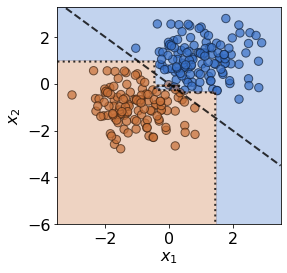

Mean training accuracy 100.00%


In [6]:
# Fit decision tree classifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# Plot
plot(X_train,y_train,true_slope,clf=clf)

# Classifier accuracy
print('Mean training accuracy %.2f%%' %(100*clf.score(X_train,y_train)))

# Fit a drift detector to the training data
from alibi_detect.cd import MMDDrift
detector = MMDDrift(X_train, backend='tensorflow', p_val=.05)

##### No drift

Before introducing drift, we first examine the case where no drift is present. We resample from the same mixture of Gaussian distributions to generate test data. The individual data observations are different, but the underlying distributions are unchanged, hence no true drift is present. 

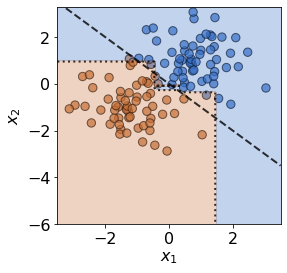

Mean test accuracy 94.17%


In [11]:
slope = true_slope

X_0 = train_norm_0.rvs(size=60,random_state=2)
X_1 = train_norm_1.rvs(size=60,random_state=2)
X_test = np.vstack([X_0, X_1])

# Plot
y_test = true_model(X_test,slope)
plot(X_test,y_test,slope,clf=clf)

# Classifier accuracy
print('Mean test accuracy %.2f%%' %(100*clf.score(X_test,y_test)))

Unsurprisingly, the model's mean test accuracy is relatively high. To run the detector on test data the `.predict()` is used:

In [8]:
detector.predict(X_test)

{'data': {'is_drift': 0,
  'distance': -0.004682348824606164,
  'p_val': 0.9,
  'threshold': 0.05,
  'distance_threshold': 0.013154105950245909},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'tensorflow'}}

As expected, since we are sampling from the distributions, the detector don't detect any covariate shift here. More specifically, the detector's p-value is above the threshold of $\alpha=0.05$, indicating that no statistically significant drift has been detected.

##### Covariate and prior drift 

To impose covariate drift, we apply a shift to the mean of one of the normal distributions:

$$
\mathbf{x}^* = \phi_1 \mathcal{N}\left(\left[-1\color{red}{+3},-1\color{red}{-3}\right]^T, \sigma^2\mathbf{I} \right) +
\phi_2 \mathcal{N}\left(\left[1,1\right]^T, \sigma^2\mathbf{I} \right)
$$


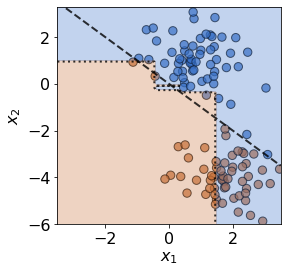

Mean test accuracy 66.67%
Is drift? Yes!


In [14]:
slope = -1.0

shift_norm_0 = sp.stats.multivariate_normal([2, -4], np.eye(2)*sigma**2)
X_0 = shift_norm_0.rvs(size=60,random_state=2)
X_1 = train_norm_1.rvs(size=60,random_state=2)
X_test = np.vstack([X_0, X_1])

# Plot
y_test = true_model(X_test,slope)
plot(X_test,y_test,slope,clf=clf)

# Classifier accuracy
print('Mean test accuracy %.2f%%' %(100*clf.score(X_test,y_test)))

# Check for drift in covariates
pred = detector.predict(X_test)
print('Is drift? %s!' %labels[pred['data']['is_drift']])

The test data has drifted into a previously unseen region of feature space, and the model is now misclassifying a number of test observations. If true test labels are avaiable, this is easily detectable by monitoring the test accuracy. However, labels aren't always avaiable during deployment, in which case a drift detector monitoring the covariates comes in handy. In this case, the trained MMD detector successfully detects the covariate drift.

In a similar manner, prior drift can be monitored by training a detector on training labels, and then feeding it a model's predicted labels:

```python
label_detector = MMDDrift(y_train.reshape(-1,1), backend='tensorflow', p_val=.05)
y_pred = clf.predict(X_test)
label_detector.predict(y_pred.reshape(-1,1))
```

##### Concept drift 

Concept drift detectors are coming soon!

### Dimension reduction <a class="anchor" id="dimension_reduction"></a>

For real-world tasks with considerably higher dimensionality, a proprocessing dimension reduction step is often needed. [Alibi Detect](https://github.com/SeldonIO/alibi-detect) allows for a high degree of flexibility here, with a user's dimension reduction technique able to be incorperated into their chosen detector via the `preprocess_fn` and `preprocess_x_ref` arguments.

Given an input dataset $\mathbf{X}\in \mathbb{R}^{N\times d}$, where $N$ is the number of observations and $d$ the number of dimensions, the aim is the reduce the data dimensionality from $d$ to $K$, where $K\ll d$. The paper [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953) presents a number of options for this task, which can be summarised into three main categories:

- **Linear projections**: This includes dimension reduction techniques such as [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and [sparse random projections (SRP)](https://doi.org/10.1145/1150402.1150436). These techniques involve using a transformation or projection matrix $\mathbf{R}$ to reduce the dimensionality of a given data matrix $\mathbf{X}$, such that $\hat{\mathbf{X}} = \mathbf{XR}$. A straightforward way to include such techniques as a pre-processing stage is to pass them to the detectors via the `preprocess_fn` argument, for example for the `scikit-learn` library's `PCA` class: 

    ```python
    pca = PCA(2)
    pca.fit(X_train)
    cd = MMDDrift(X_train, backend='tensorflow', p_val=.05, preprocess_fn=pca.transform)
    ```

- **Auto-encoders**: Untrained (UAE) or trained (TAE)

- **Black-box Shift Detectors (BBSD)**:


Schematic showing possible BBSD outputs



## 2. Online detection <a class="anchor" id="online"></a>

## 3. Learned drift detection <a class="anchor" id="classifiers"></a>

